# Classification multi-classe avec un modèle linéaire

Dans ce notebook, nous allons voir les bases de PyTorch en considérant un exemple de problème de classification linéaire multi-classe.

Nous allons :
- Présenter le jeu de données MNIST, qui contient des images de 28x28 pixels de chiffres écrits à la main.
- Introduire l'utilisation de PyTorch pour construire et entraîner des modèles.
- Explorer l'effet de certains paramètres sur notre modèle :
    - Taille de l'ensemble de données
    - Taille des mini-batchs ("mini-lots")
    - Régularisation


## MNIST

Le jeu de données MNIST contient des chiffres manuscrits (numériques) en noir et blanc, d'une taille de 28x28 pixels. Ce jeu de données est généralement utilisé pour les démonstrations de modèles d'apprentissage automatique.

Nous allons télécharger le jeu de données. Pour simplifier, nous n'utiliserons que les 2500 premières images de la base de données MNIST.
La première fois que vous exécuterez ce code, l'ensemble de données MNIST sera téléchargé.


In [1]:
from torchvision import datasets

# charger le subset train
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_train = list(mnist_train)[:2500]

print(mnist_train[0])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

(<PIL.Image.Image image mode=L size=28x28 at 0x7F257BE2FE20>, 5)


Regardons quelques images du dataset :

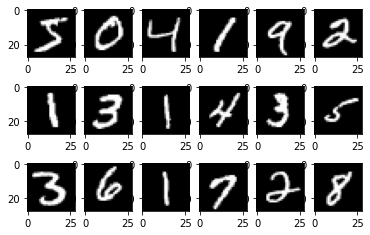

In [2]:
# plot des 18 premières images de train
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(mnist_train[:18]):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')

In [3]:
from torchvision import transforms
# transformer l'image en une matrice pytorch de taille 28x28 :
img_to_tensor = transforms.ToTensor()

img_tensor = img_to_tensor(image)
img_tensor.shape

torch.Size([1, 28, 28])

Pour convertir l'ensemble des images en ces représentations tensorielles (par opposition aux objets PIL.Image), il existe un paramètre `transform` que nous pouvons utiliser lors du chargement de MNIST :

In [4]:
mnist_train = datasets.MNIST('data', train=True, transform=img_to_tensor)
mnist_train = list(mnist_train)[:2500]
print(mnist_train[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Maintenant, nous allons diviser ces données en deux parties, train et val, et commencer à construire un modèle très simple.

Nous n'aurons pas besoin d'un ensemble de test dans cet exemple, mais en général, il faudrait charger (ou créer s'il n'existe pas) un ensemble de test.

In [5]:
mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

## Modèle linéaire en PyTorch

Pour construire un modèle linéaire dans PyTorch, nous utilisons une instance de la classe `nn.Linear`, et en spécifiant le nombre de features d'entrée, et le nombre de features de sortie désiré. Pour la régression linéaire et la classification binaire, la dimension de sortie est 1. Pour la classification multi-classes, nous avons autant de sorties qu'il y a de classes.

Lorsque nous utilisons ce modèle pour la classification, nous devons appliquer l'activation sigmoïde ou softmax *à la suite*.

In [6]:
import torch
import torch.nn as nn

model_exemple = nn.Linear(50, 1) # 50 features en entrée, 1 seule sortie

L'objet `model_exemple` contient les poids (weights) et les biais (biases, un seul ici) du modèle. Par défaut, PyTorch initialise leurs valeurs à un nombre aléatoire proche de 0 :

In [7]:
weight, bias = list(model_exemple.parameters())
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[-0.1003, -0.0206, -0.1398, -0.0345, -0.1236, -0.0652,  0.0926,  0.0567,
         -0.1016,  0.0178,  0.1241, -0.0351, -0.0086, -0.0272, -0.0736,  0.0421,
          0.0844, -0.0568,  0.0874, -0.0862,  0.0453,  0.0488, -0.0335, -0.0393,
          0.0394,  0.1329,  0.1024,  0.1019, -0.0558, -0.1323, -0.1299, -0.0600,
         -0.1162, -0.1074,  0.0914, -0.1368,  0.0248,  0.0804,  0.0800,  0.0168,
          0.1312, -0.0328, -0.0249, -0.0502,  0.0297,  0.1082,  0.0878, -0.1362,
         -0.0252, -0.0402]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.1341], requires_grad=True)
torch.Size([1])


Si l'on instancie un nouveau modèle, ses paramètres ne seront pas les mêmes :

In [8]:
model_exemple = nn.Linear(50, 1)
weight, bias = list(model_exemple.parameters())

# Les valeurs affichées ci-dessous sont différentes des valeurs de la cellule précédente
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[ 0.1051,  0.0698,  0.0295,  0.0630,  0.0322,  0.0251,  0.0205,  0.1125,
         -0.0139,  0.0610, -0.0999, -0.0982,  0.0368, -0.0585,  0.1035, -0.1318,
          0.0301,  0.0857, -0.1333, -0.0333, -0.0412, -0.0261,  0.0972, -0.1231,
         -0.0269,  0.0248,  0.0517, -0.0675, -0.0516, -0.0068, -0.0363, -0.1326,
         -0.0892,  0.0286,  0.0680,  0.0685,  0.0718,  0.0426, -0.1060,  0.1273,
          0.1093, -0.0160, -0.0653,  0.1284, -0.0153, -0.0459, -0.0208, -0.1002,
          0.1327, -0.0732]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([0.0825], requires_grad=True)
torch.Size([1])


Créons maintenant le modèle basique pour les images MNIST vectorisées.

Combien de features avons-nous pour une image ? 

Combien de sorties avons-nous ?

In [9]:
model = nn.Linear(784, 10) # 784 = 28*28

# vérifions les dimensions des poids et biais : 
weight, bias = list(model.parameters())
print(weight.shape)
print(bias.shape)

torch.Size([10, 784])
torch.Size([10])


## Faire des prédictions

Voyons comment faire une prédiction avec ce modèle, dont les paramètres sont initialisés aléatoirement et qui n'a pas encore été entraîné. 

Quel taux de bonne classification (*accuracy*) attendre d'un tel modèle sur MNIST ?

Pour faire des prédictions avec `model`, il faut une entrée $x$ qui a la forme requise. Une bonne façon de tester que l'on a défini un modèle comme on le souhaite est de le tester sur un tenseur avec la forme appropriée, rempli de valeurs aléatoires.

In [10]:
x = torch.randn(784) # crée une tenseur de rang 1 (vecteur) avec 784 features
x.shape

torch.Size([784])

Pour faire des prédictions, en PyTorch, on applique `model` comme une fonction, avec l'input en entrée :

In [11]:
y = model(x)
y.shape, y

(torch.Size([10]),
 tensor([ 0.0706, -1.1140, -0.4782,  1.2993, -0.7317, -0.4423,  1.6598,  0.8015,
         -1.0290, -0.5145], grad_fn=<AddBackward0>))

La sortie est un vecteur de dix nombres réels. 

Si nous faisions de la classification binaire, nous pourrions être intéressés par normaliser ces scores pour obtenir des probabilités. Nous pouvons utiliser la fonction d'activation `sigmoid` pour cela. 


Remarquons que MNIST comporte dix classes mutuellement exclusives, si nous voulons normaliser les scores des dix classes , ce n'est pas `sigmoid` mais `softmax` que nous utiliserons par la suite. 

In [12]:
torch.sigmoid(model(x))

tensor([0.5176, 0.2471, 0.3827, 0.7857, 0.3248, 0.3912, 0.8402, 0.6903, 0.2633,
        0.3741], grad_fn=<SigmoidBackward0>)

L'un des avantages de PyTorch est qu'il vectorise et parallélise le calcul pour nous.

Ainsi, si nous avons un *batch* de 32 entrées pour lesquelles nous voulons faire des prédictions, nous pouvons effectuer ce calcul en utilisant un seul appel :

In [13]:
x = torch.randn([32, 784]) # une pile de 32 inputs, un "mini-batch" de 32 exemples
print(x.shape)
y = model(x)
print(y.shape)

torch.Size([32, 784])
torch.Size([32, 10])


Note : L'ordre des dimensions de $x$ est important. La taille du mini-batch passe toujours en premier, et le nombre de features à la suite.

Maintenant, essayons de faire quelques "prédictions" avec notre modèle, sur la variable `image_tensor` de tout à l'heure :

In [14]:
img_tensor.shape

torch.Size([1, 28, 28])

Cependant, la forme de ce tenseur n'est pas celle dont nous avons besoin.

Nous devons *flatten* l'image soit en un tenseur de rang 1 (de dimension [784]),soit un tenseur de rang 2 ([1, 784]). 

Nous choisirons le dernier, de sorte que que la transition vers le passage de plusieurs images en même temps soit plus facile :

In [15]:
x = img_tensor.view(1, 784)
print(x.shape)
z = model(x)
print(z)
print(z.shape)
y = torch.softmax(z, dim=1)
print(y)

torch.Size([1, 784])
tensor([[-0.3236,  0.1055, -0.1152,  0.0518, -0.1000,  0.2595, -0.2139, -0.0547,
         -0.2615, -0.3514]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])
tensor([[0.0786, 0.1207, 0.0968, 0.1144, 0.0983, 0.1408, 0.0877, 0.1028, 0.0836,
         0.0764]], grad_fn=<SoftmaxBackward0>)


Le `dim=1` dans le softmax indique à PyTorch sur quelle dimension appliquer la fonction. Nous voulons que les sorties $y$ soient une distribution de probabilité à travers les *classes* (`dim=1`), et non pas les différentes images (`dim=0`).

## Loss (fonction de perte)

Pour que le réseau soit vraiment utile, nous devons l'entraîner, de sorte que
que les poids aient des valeurs non aléatoires, pertinentes pour la tâche de classification. Nous utiliserons le réseau pour faire des prédictions, puis nous comparerons les prédictions à la vérité de base via la fonction de perte.

Exemples de fonctions de perte standards pour la classification :  

*   `nn.BCEWithLogitsLoss()` : classification binaire
*   `nn.CrossEntropyLoss()` : classification multi-classe


In [16]:
criterion = nn.CrossEntropyLoss()

Ce critère peut également être appelé comme une fonction. Il prend comme paramètres des prédictions appelées `logit` et les labels, et renvoie une valeur réelle (la perte ou la loss pour un mini-batch donné). Deux choses à garder à l'esprit pour cette fonction :

1. Les fonctions de perte comme celle-ci prennent généralement les **logits** en entrée, qui sont les valeurs (scores) réelles issues de la dernière couche d'un réseau de neurones, avant application d'une fonction d'activation (sigmoid ou softmax). Il s'agit des préactivations. Ceci pour des raisons de stabilité numérique.
2. Cette fonction de perte prend l'indice entier pour les labels, **index**, plutôt qu'un vecteur one-hot.

In [17]:
loss = criterion(y, torch.Tensor([8]).long()) # digit 8 = la 8ème classe
print(loss)

tensor(2.3192, grad_fn=<NllLossBackward0>)


## Optimisation et régularisation L2 ("Weight Decay")

PyTorch calcule les dérivées pour nous en utilisant la *différenciation automatique* avec les principes vus en cours.

Nous devons spécifier un **optimiseur** (comme la descente de gradient stochastique), et utiliser l'optimiseur pour déterminer comment mettre à jour les poids pendant l'apprentissage.

In [18]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.005) # lr = learning rate

# Voici les trois lignes de code nécessaires pour faire 
# une itération de descente de gradient :
loss.backward()       # calcule les gradients par rapport aux poids et biais du réseau
optimizer.step()      # modifie les poids et biais
optimizer.zero_grad() # met à zéro les tenseurs des gradients sinon ils sont accumulés d'une itération à l'autre

Nous pouvons également ajouter une régularisation $\ell_2$ via l'optimiseur avec l'option `weight_decay` :

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.01)

## Produire des mini-batchs : "batching"

Au premier TP, nous avions générer nous-mêmes des mini-batchs de données. L'objet DataLoader de PyTorch permet d'instancier un itérateur pour créer des minibatchs :

In [20]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=32, 
                                           shuffle=True)  # shuffle avant chaque epoch

for (xs, ts) in enumerate(train_loader):
    print(xs) # image (pixels)
    print(ts) # targets ou labels
    break

# Essayez de changer batch_size 

0
[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...,

## Mettons tout cela ensemble

In [21]:
def run_gradient_descent(model,
                         batch_size=64,
                         learning_rate=0.01,
                         weight_decay=0,
                         num_epochs=10):
    """fonction qui réalise l'entraînement de model sur mnist_train et mesure l'accuracy sur mnist_train et mnist_val régulièrement"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_acc, val_acc  = [], [] ,[]

    train_loader = torch.utils.data.DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True)

    # Boucles d'apprentissage
    n = 0 # nombre d'itérations
    for epoch in range(num_epochs):
        for xs, ts in iter(train_loader):
            if len(ts) != batch_size:
                continue
            xs = xs.view(-1, 784)    # flatten. Le -1 est un "joker"
            zs = model(xs)
            loss = criterion(zs, ts) # calcul de la loss
            loss.backward()          # calcul des gradients
            optimizer.step()         # faire les updates
            optimizer.zero_grad()    # mise à zéro des gradients

            # pour plots futurs
            iters.append(n)
            losses.append(float(loss)/batch_size)  # calcul de la loss moyenne

            if n % 10 == 0:
                iters_sub.append(n)
                train_acc.append(get_accuracy(model, mnist_train))
                val_acc.append(get_accuracy(model, mnist_val))
            # incrémenter l'itération
            n += 1

    # plot
    plt.title("Training avec batch_size={}, lr={}".format(batch_size, learning_rate))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training avec batch_size={}, lr={}".format(batch_size, learning_rate))
    plt.plot(iters_sub, train_acc, label="Train")
    plt.plot(iters_sub, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    return model

def get_accuracy(model, data):
    """fonction qui calcule le taux de bonne classification (accuracy)"""
    loader = torch.utils.data.DataLoader(data, batch_size=500)

    correct, total = 0, 0
    for xs, ts in loader:
        xs = xs.view(-1, 784) # flatten 
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] 
        correct += pred.eq(ts.view_as(pred)).sum().item()
        total += int(ts.shape[0])
        return correct / total

Entraînons le modèle. Commenter les courbes obtenues.

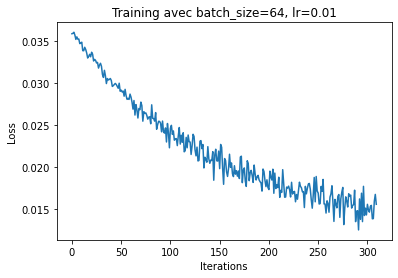

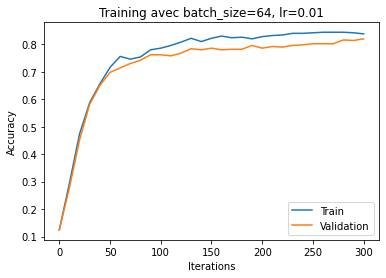

Linear(in_features=784, out_features=10, bias=True)

In [22]:
model = nn.Linear(784, 10)
run_gradient_descent(model, batch_size=64, learning_rate=0.01, num_epochs=10)

## À vous d'essayer :

- Changer la batch size
- Changer le weight decay 
- Réduire la taille du subset de train
- Changer le learning rate


## La suite ? 

- Comment définir un modèle plus complexe avec plus d'une couche ?
Réponse dans le prochain sujet !